# Density Drift Detection

In this notebook you will learn what is and how to use the `DensityDriftDetector` available on Mercury.

This module is aimed at detecting anomalies with respect to a certain training/reference dataset. The philosophy is that a "drifted" (considering "drift" = "covariate shift") dataset will present a higher number of anomalies than a "normal" dataset.

The main idea is to use a variational autoencoder that learns a mapping from the input distribution $P(X)$ to the embedding space, $P(Z)$. Under normal conditions, if $P(X)$ doesn't change, the embeddings, $z$, will be still distributed as the learnt $P(Z)$. On the contrary, if $P(X)$, changes, new $z$s will fall on low density zones of $P(Z)$.

For doing the above the method proceeds as follows:

- A neural net (VAE) is trained on a reference dataset which presents no drift. 
- Then, a density estimation of the embedding space is made.
- A surrogate model (small MLP) is fitted to that estimate.

During inference, a certain $x'$ is provided, its embedding $z'$ is calculated and the surrogate model predicts the value of the pdf. at that point $z'$. If $x'$ is an anomaly, we can expect it to have a small value.

In case you don't care about individual instances and only need to flag new batches of data you may want to take a look at other dectectors in Mercury based on the `BatchDriftDetector` schema.

Let us see how it works on two practical examples!

In [1]:
from mercury.monitoring.drift.density_drift_detector import DensityDriftDetector

from mercury.dataschema import DataSchema
from mercury.dataschema.feature import FeatType

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

## Build Dataset



### Wine

We use the wine quality dataset [[1]](#[1]) dataset. The files of this dataset are available inside of the /data/winequality folder in tutorials and it is also available in the [UCI ML repository](https://archive.ics.uci.edu/ml/datasets/wine+quality) 

Each row of the dataset represents a different wine and it contains attributes like the acidity of the wine or the level of alcohol. The dataset also contains the quality of the wine, ranging from 0 to 10. 

With this dataset we simulate we have a wine warehouse and, with time, we start receiving wines that have an increasingly quantity of alcohol.

In [3]:
# Util function for processing the dataset. Ignore it
def get_wine_splits():
    df_red_wines = pd.read_csv("../data/winequality/winequality-red.csv")
    df_white_wines = pd.read_csv("../data/winequality/winequality-white.csv")

    df_red_wines["type"] = "red"
    df_white_wines["type"] = "white"

    df = pd.concat([df_red_wines, df_white_wines])

    # Create id
    df["id"] = np.arange(df.shape[0])

    # Encode Label
    df["quality"] = df["quality"].apply(lambda x: 1 if x >=7 else 0)

    # Encode Type
    le = preprocessing.LabelEncoder()
    df["type"] = le.fit_transform(df["type"])

    # Set attribute to indicate high alcohol
    df["high_alcohol"] = df["alcohol"].apply(lambda x: True if x > 11 else False)

    # Time will represent the moment we have that data
    df["time"] = -1

    # For those rows with high alcohol, we set 70% of them as time 0 (they will be used as training)
    df["time"] = df.apply(
        lambda x: 0 if (x["high_alcohol"] == False) and (np.random.uniform() < 0.7) else -1, axis=1
     )

    # Each timestep, new amount of samples low_alcohol and high_alcohol
    n_samples_low_alcohol = [250, 245, 230, 210, 180, 140, 30]
    n_samples_high_alcohol = [0, 5, 10, 20, 40, 80, 160]
    max_timesteps = 7
    for t in range(1, max_timesteps + 1):
        # Sample examples with high_alcohol == True
        n_samples = n_samples_high_alcohol[t-1]
        sampled_ids = df[(df["time"] == -1) & (df["high_alcohol"] == True)].sample(
            n_samples, random_state=2021)["id"].values
        df.loc[df["id"].isin(sampled_ids), "time"] = t
        # Sample examples with high_alcohol == False
        n_samples = n_samples_low_alcohol[t-1]
        sampled_ids = df[(df["time"] == -1) & (df["high_alcohol"] == False)].sample(
            n_samples, random_state=2021)["id"].values
        df.loc[df["id"].isin(sampled_ids), "time"] = t 
        
    
    df_initial = df[df["time"] == 0]    
    label = 'quality'
    features = [c for c in df.columns if c not in [label, 'time', 'high_alcohol', 'id', 'type']]

    X_initial = df_initial[features]
    
    X_src = X_initial.copy()
    X_t1 = df[df["time"] == 1][features].copy()
    X_t6 = df[df["time"] == 7][features].copy()
    
    return X_src, X_t1, X_t6, df

We have 3 splits. A reference one on which will train our detector, a version which presents none (or very little) drift and a one which is clearly drifted (the one when much time has passed)

In [4]:
np.random.rand(42) # Reproducible results

wine_source, wine_nodrift, wine_drift, wine_orig = get_wine_splits()

Here we can see a graphic representation of the above explanation. We start at time 1 with lots of wines with low alchol level and, as time passes, the high quantity alcohol vines start to increase.

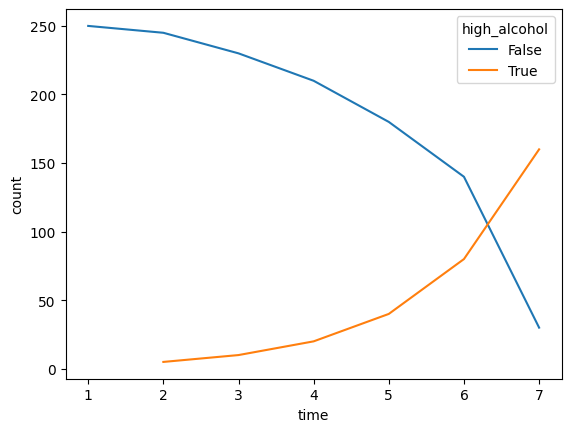

In [5]:
sample_counts = wine_orig.groupby(["time", "high_alcohol"])["id"].count().to_frame().reset_index()
sample_counts = sample_counts.rename(columns={"id": "count"})
sample_counts = sample_counts[sample_counts["time"] > 0]
ax = sns.lineplot(x="time", y="count", hue="high_alcohol", data=sample_counts)

As this method relies on neural networks we must normalize the inputs. Luckily we have an `Autonormalizer` class available in `mercury.contrib` which we can leverage.

In [6]:
wine_source.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(wine_source)
wine_source.loc[:, wine_source.columns] = scaler.transform(wine_source)
wine_nodrift.loc[:, wine_nodrift.columns] = scaler.transform(wine_nodrift)
wine_drift.loc[:, wine_drift.columns] = scaler.transform(wine_drift)

Let's take a look at how different is the feature `alcohol` between the splits.

Text(0.5, 1.0, 'Alcohol  Drift')

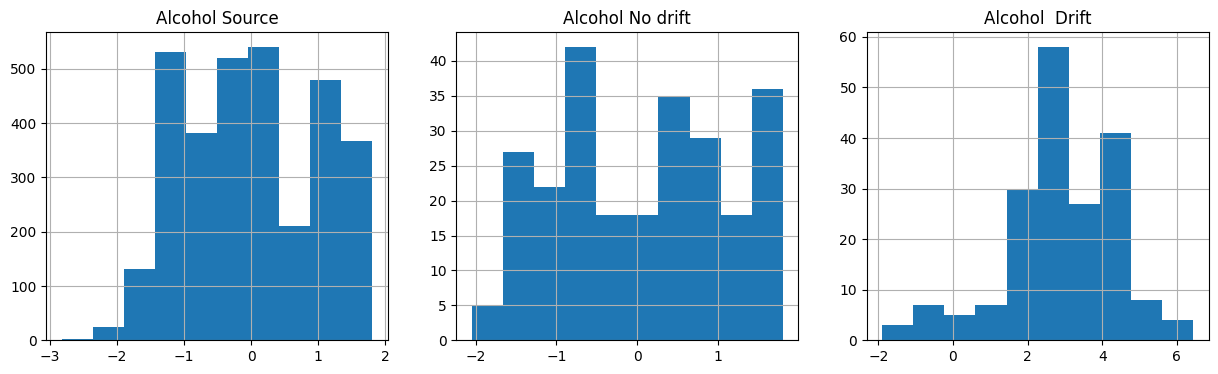

In [8]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
wine_source.alcohol.hist(ax=ax[0])
wine_nodrift.alcohol.hist(ax=ax[1])
wine_drift.alcohol.hist(ax=ax[2])

ax[0].set_title("Alcohol Source")
ax[1].set_title("Alcohol No drift")
ax[2].set_title("Alcohol  Drift")

## Drift Detection

In [9]:
# Start by training a density detector on the reference data
detector_wine = DensityDriftDetector().fit(wine_source, batch_size=32)

2023-04-05 10:41:58.546164: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-05 10:41:58.546543: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


2023-04-05 10:41:58.785972: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-05 10:41:58.788845: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100


2023-04-05 10:41:59.079646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 2s 10ms/step - loss: 32.4029 - reconstruction_loss: 31.8985 - kl_loss: 0.1062
Epoch 2/100
100/100 [==============================] - 1s 8ms/step - loss: 31.4109 - reconstruction_loss: 28.1281 - kl_loss: 0.9939
Epoch 3/100
100/100 [==============================] - 1s 8ms/step - loss: 25.7684 - reconstruction_loss: 22.4701 - kl_loss: 1.9127
Epoch 4/100
100/100 [==============================] - 1s 8ms/step - loss: 23.4858 - reconstruction_loss: 20.4476 - kl_loss: 1.9676
Epoch 5/100
100/100 [==============================] - 1s 7ms/step - loss: 21.2714 - reconstruction_loss: 18.9824 - kl_loss: 2.1643
Epoch 6/100
100/100 [==============================] - 1s 7ms/step - loss: 20.3606 - reconstruction_loss: 18.1404 - kl_loss: 2.2843
Epoch 7/100
100/100 [==============================] - 1s 8ms/step - loss: 20.4899 - reconstruction_loss: 17.4543 - kl_loss: 2.4905
Epoch 8/100
100/100 [==============================] - 1s 8ms/step - loss: 18.8955 - re

2023-04-05 10:42:32.399935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 4ms/step - loss: 0.0453
Epoch 2/100
313/313 [==============================] - 1s 4ms/step - loss: 0.0013
Epoch 3/100
313/313 [==============================] - 1s 3ms/step - loss: 9.4082e-04
Epoch 4/100
313/313 [==============================] - 1s 3ms/step - loss: 8.7490e-04
Epoch 5/100
313/313 [==============================] - 1s 3ms/step - loss: 8.5197e-04
Epoch 6/100
313/313 [==============================] - 1s 3ms/step - loss: 8.3970e-04
Epoch 7/100
313/313 [==============================] - 1s 3ms/step - loss: 8.2997e-04
Epoch 8/100
313/313 [==============================] - 1s 3ms/step - loss: 8.2014e-04
Epoch 9/100
313/313 [==============================] - 1s 3ms/step - loss: 8.0894e-04
Epoch 10/100
313/313 [==============================] - 1s 3ms/step - loss: 7.9621e-04
Epoch 11/100
313/313 [==============================] - 1s 3ms/step - loss: 7.8168e-04
Epoch 12/100
313/313 [==============================] - 1s 3ms/step - lo

313/313 [==============================] - 1s 3ms/step - loss: 4.6682e-06
Epoch 96/100
313/313 [==============================] - 1s 3ms/step - loss: 3.9104e-06
Epoch 97/100
313/313 [==============================] - 1s 3ms/step - loss: 3.7271e-06
Epoch 98/100
313/313 [==============================] - 1s 3ms/step - loss: 4.2677e-06
Epoch 99/100
313/313 [==============================] - 1s 3ms/step - loss: 3.8294e-06
Epoch 100/100
313/313 [==============================] - 1s 3ms/step - loss: 3.9984e-06


In [10]:
# We predict densities for both the no-drift and drift splits
probs_no_drift = detector_wine.predict(wine_nodrift).ravel()
probs_drift = detector_wine.predict(wine_drift).ravel()

# As we're using an autoencoder, we can also obtain data embeeddings
embeddings_nodrift = detector_wine.predict_embeddings(wine_nodrift)
embeddings_drift = detector_wine.predict_embeddings(wine_drift)

Let us take a look at the predicted density distributions for both splits

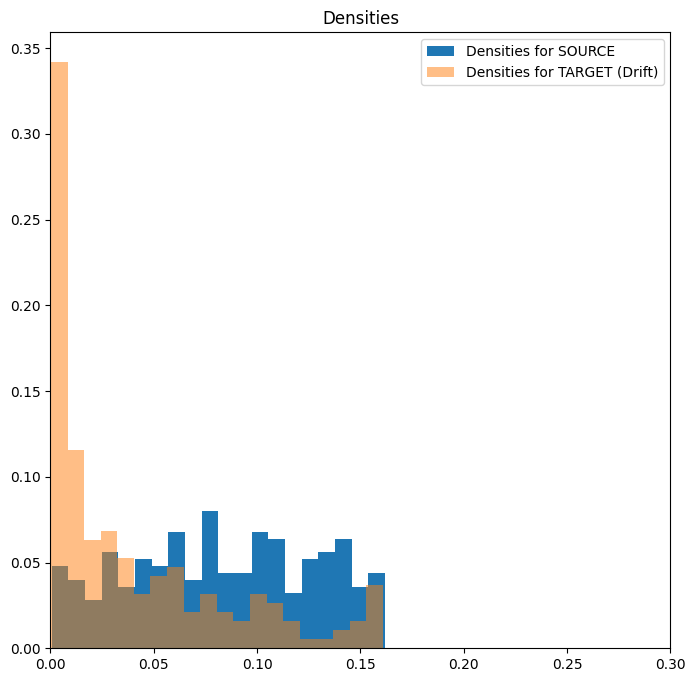

In [11]:
fig, ax = plt.subplots(figsize=(8,8))

ax.hist(probs_no_drift, bins=20, label='Densities for SOURCE',
        weights=[1/len(probs_no_drift) for _ in range(len(probs_no_drift))])
ax.hist(probs_drift, bins=20, label='Densities for TARGET (Drift)', alpha=.5,
        weights=[1/len(probs_drift) for _ in range(len(probs_drift))])

ax.set_xlim((0, 0.3))
ax.set_title("Densities")
ax.legend()

As we can see, the densities for the drifted data tend to be smaller (look at the mode on lower density values), meaning drifted embeddings fall under low probability regions in the embedding space.

One could "hard label" individual points with a custom threshold (for example, the 2nd percentile).

### Embedding space visualization

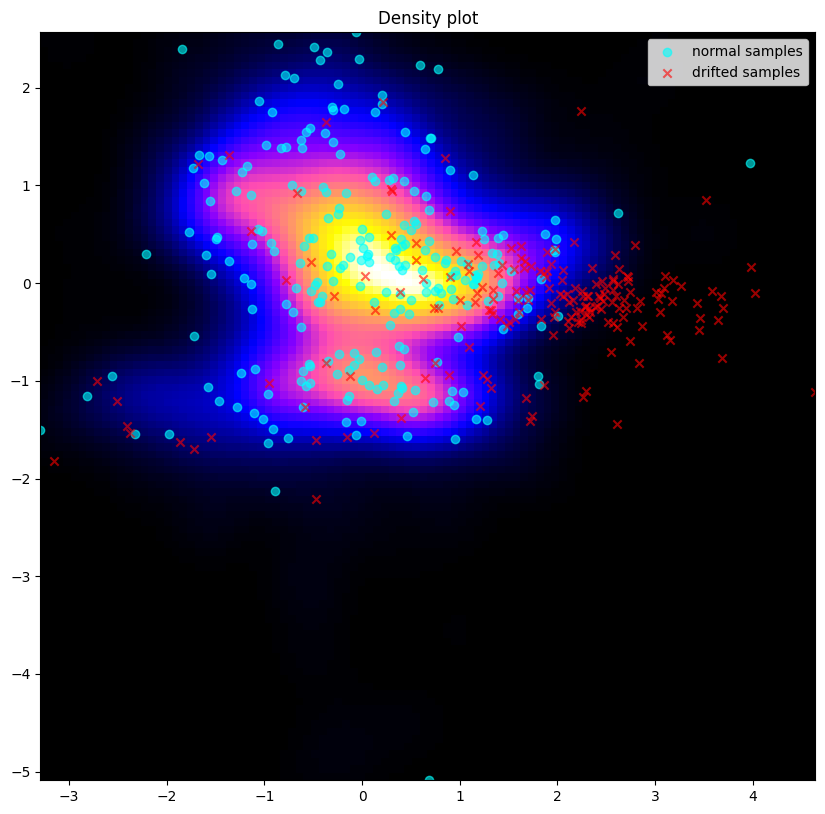

In [12]:
xmin = min(np.min(embeddings_nodrift[:,0]), np.min(embeddings_drift[:,0]))
xmax = max(np.max(embeddings_nodrift[:,0]), np.max(embeddings_drift[:,0]))
ymin = min(np.min(embeddings_nodrift[:,1]), np.min(embeddings_drift[:,1]))
ymax = max(np.max(embeddings_nodrift[:,1]), np.max(embeddings_drift[:,1]))


fig, ax = plt.subplots(figsize=(10,10))

X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])

Z = np.reshape(detector_wine.kde(positions), X.shape)
ax.imshow(np.rot90(Z), cmap=plt.cm.gnuplot2,
          extent=[xmin, xmax, ymin, ymax])

ax.scatter(embeddings_nodrift[:,0], embeddings_nodrift[:,1], marker='o', alpha=.6, color='cyan', label='normal samples')
ax.scatter(embeddings_drift[:,0], embeddings_drift[:,1], marker='x', alpha=.6, color='r', label='drifted samples')

ax.set_title("Density plot");
plt.legend()

The above plot depicts the 2-d embedding space (by default the embedding space of the VAE will be 2). 

As it can be seen, blue points (no drifted) tend to fall on zones with relatively high density, whereas "x"s (drifted points) fall under low probability regions.

### Surrogate density approximation

After having fitted the detector, a surrogate model (which is another neural net) is fitted to the gaussian KDE estimation of the embedding space. This step is done because, when serializing the detector, we can simply save the two models (both VAE and surrogate), requiring less disk space and faster inference.

In the following plots, we see how the surrogate approximates the "true" density estimation by a gaussian KDE.

In [13]:
true_densities = detector_wine.kde(positions)
pred_densities = detector_wine.surrogate(positions.T)

Text(0.5, 1.0, 'Density estimation (using surrogate model)')

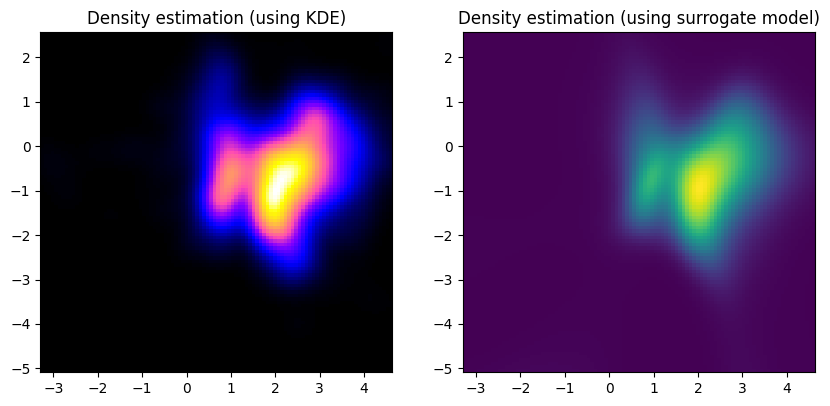

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))

Z = np.reshape(true_densities, X.shape)
ax[0].imshow(Z, cmap=plt.cm.gnuplot2,
          extent=[xmin, xmax, ymin, ymax])

Z = np.reshape(pred_densities, X.shape)
ax[1].imshow(Z, cmap=plt.cm.viridis,
          extent=[xmin, xmax, ymin, ymax])

ax[0].set_title("Density estimation (using KDE)")
ax[1].set_title("Density estimation (using surrogate model)")

## Caveats

This method is based on neural networks, so the normalization (specially with tabular data) plays a very important role on how you provide your data (both source and target) to the detector. With wrong normalization methods separation in the embedding space could not be possible. If you don't know where to start, try the basics: **standarize numerics and one-hot encode categoricals**.

Despite of that, during testing, we found this method tends to work better if you have the majority of the features of a continuous type.


### How do I know whether the detector will work correctly if I don't have access to drifted data?

The most usual case is that you don't have access to drifted data when building your detector (i.e. you only have a SOURCE distribution). In such situations, a possible approximation would be to take your SOURCE dataset and "artificially" perturb it in ways you expect drift could be possible when deployed (e.g. one variable increases, other becomes null, other decreases, etc.) and pass, to a trained detector and make sure that the predicted densities for the perturbed dataset are lower than the ones predicted for the SOURCE data (i.e. the distribution are left-shifted, like on the former examples).



### How do I know if my data presents drift?

This method applies an "anomaly detection" philosophy for detecting drift. It assumes that if the $P(X)$ changes, the distribution of the embeddings ($P(Z)$) will also change, moving to zones of low density. So the best approximation would be to:

- Look at the distributions of artificially drifted data (or real drifted samples if you have them) and get a low percentile as a threshold, for example $10$.
- Use that value to mark drifted samples once monitoring and count how many of them you have.
- Above a certain threshold you could raise an alert.

In [15]:
# Get the 10th percentile
preds = detector_wine.predict(wine_source).flatten()
threshold_detection = np.percentile(preds, 10)
threshold_detection

0.019905265793204313

Using threshold 0.019905265793204313 -> Anomalies: 90 | Percent anomalies 0.47368421052631576


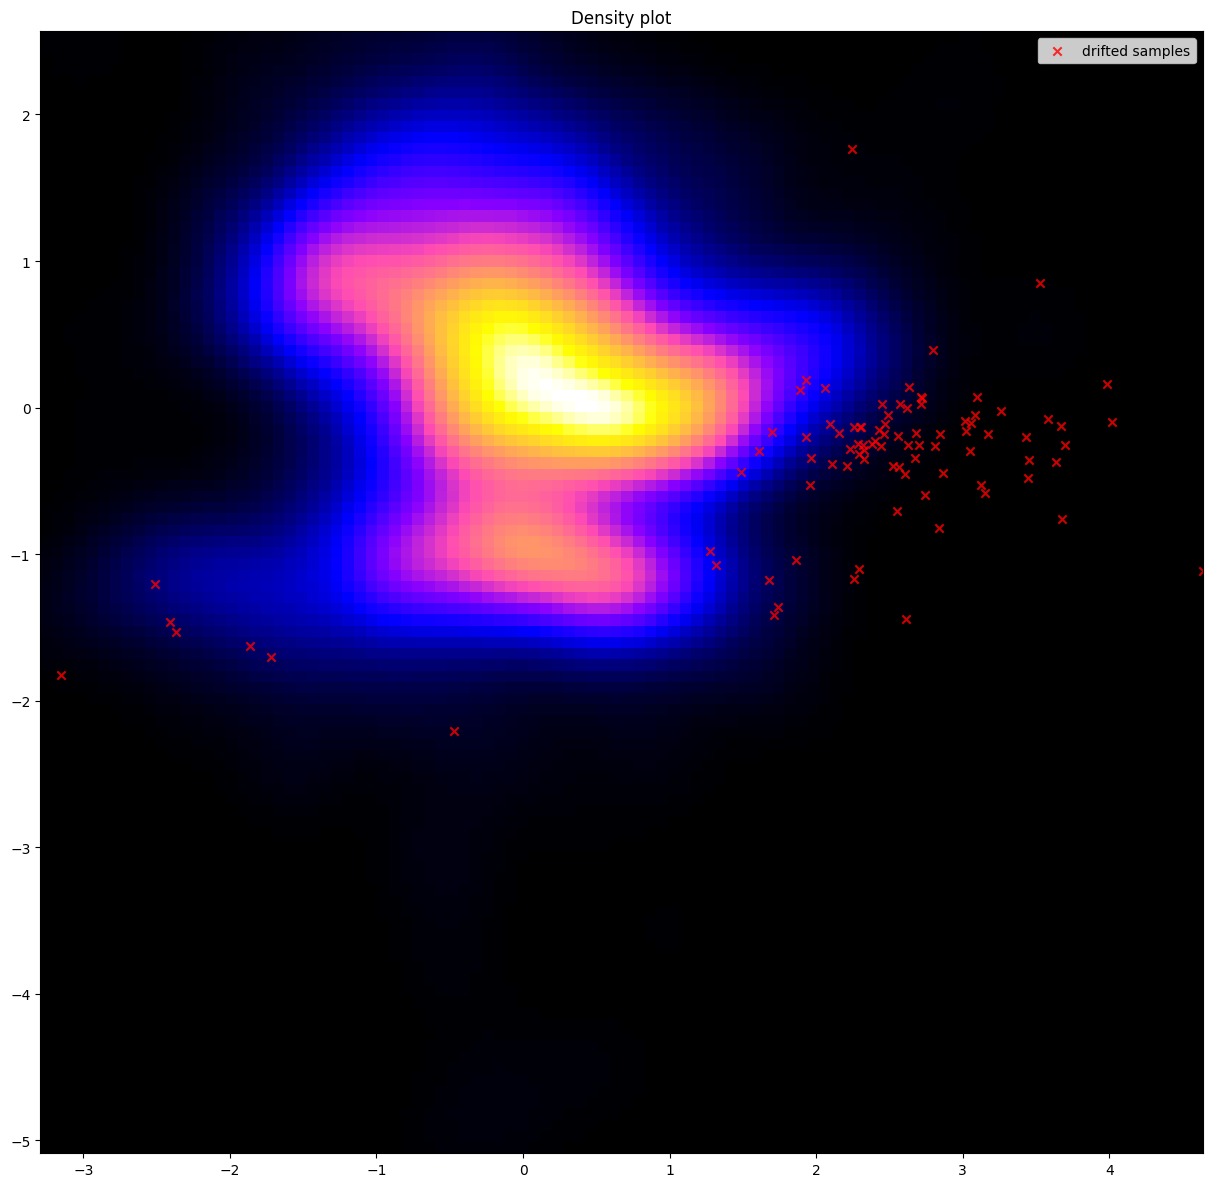

In [16]:
# Plot only samples below the selected percentile
is_anomaly = probs_drift < threshold_detection

fig, ax = plt.subplots(figsize=(15,15))

# Plot density map
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(detector_wine.kde(positions).T, X.shape)
ax.imshow(np.rot90(Z), cmap=plt.cm.gnuplot2,
          extent=[xmin, xmax, ymin, ymax])

ax.scatter(embeddings_drift[is_anomaly,0], 
           embeddings_drift[is_anomaly,1], marker='x', alpha=.8, color='red', label='drifted samples')

ax.set_title("Density plot");
plt.legend()

print(f"Using threshold {threshold_detection} -> Anomalies: {is_anomaly.sum()} | Percent anomalies {is_anomaly.sum()/len(is_anomaly)}")

## BONUS: Explainability – WHY is my sample an outlier?

Flagging outliers is quite nice, but it would be even better if we could get **explanations** on whether a particular sample has drifted... Luckily for us, as we're leveraging autoencoders we can obtain them!

We will consider an "explanation" as the amount each feature has to change in order that sample to become an inlier (or any other point really), i.e. the "delta". 

Thus, for obtaining it the method will recieve a sample $x$ we want to explain and a reference point (default is the highest density point in the embedding space, but you could specify any you want). Then:

1. The reference point will be reconstructed with the decoder ($p$)
2. A "delta" (i.e. explanation) will be calculated by substracting $x$ to the reconstructed point ($p - x$)

This delta will be the amount we have to change on the inputs ($x$) so that it becomes the same point as $p$.

Let's see an example. We'll begin by choosing a point we know is "normal"/"inlier" and manually corrupt it so it becomes an anomaly/outlier.

In [17]:
# Find the "most normal" datapoint
preds = detector_wine.predict(wine_source).flatten()
x = wine_source.iloc[preds.argmax()]
x

fixed acidity          -0.864553
volatile acidity       -0.841402
citric acid             1.154779
residual sugar         -0.910320
chlorides               0.088141
free sulfur dioxide    -0.807961
total sulfur dioxide    0.334422
density                -0.922283
pH                      0.035467
sulphates              -0.112122
alcohol                -0.968988
Name: 1617, dtype: float64

We'll use this $x$ as an illustrative purpose. We now simulate "drift" by changing the values of several of its features

In [18]:
altered_x = x.copy()

# Lets change "AGE" and "PERSONAL_NET_INCOME" values
altered_x.pH -= 2
altered_x.density += 5

altered_x

fixed acidity          -0.864553
volatile acidity       -0.841402
citric acid             1.154779
residual sugar         -0.910320
chlorides               0.088141
free sulfur dioxide    -0.807961
total sulfur dioxide    0.334422
density                 4.077717
pH                     -1.964533
sulphates              -0.112122
alcohol                -0.968988
Name: 1617, dtype: float64

Now, we can estimate the amount we must change `altered_x` so it becomes a "normal" datapoint:

In [19]:
explanation = detector_wine.explain(
    altered_x.values[np.newaxis,...]
).flatten()

In [20]:
explanation

array([ 0.5118539 ,  0.26365292, -1.0297803 ,  0.6167052 , -0.40780663,
        0.69601864, -0.12498392, -4.9299726 ,  1.7133162 , -0.20461565,
        1.4273951 ], dtype=float32)

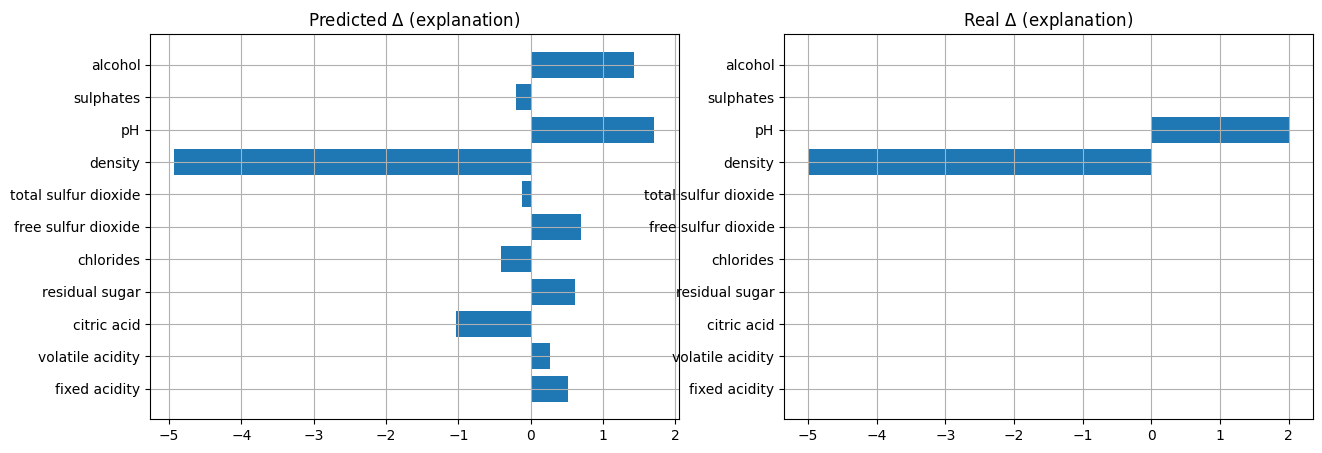

In [21]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].grid()
ax[1].grid()

ax[0].barh(wine_source.columns.tolist(), explanation )
ax[1].barh(wine_source.columns.tolist(), (x - altered_x).values)

ax[0].set_title("Predicted $\Delta$ (explanation)")
ax[1].set_title("Real $\Delta$ (explanation)");

As you can see, the predicted delta indicates that, in order our sample $x$ to become "normal", we should substract around -5 to `density` and add  around 2 to `pH`, which is the exact opposite to what we did above.

We can try the same but in "batch mode", namely, we can take the "most anomaly" samples from the drifted set and obtain explanations for each one of the samples.

In [22]:
preds = detector_wine.predict(wine_drift).flatten()
embeddings_drift = detector_wine.predict_embeddings(wine_drift)

# Get the 10th percentile
threshold_detection = np.percentile(preds, 10)
is_anomaly = preds < threshold_detection

Let's visualize the sample plot as before.

Using threshold 0.000974093790864572 -> Anomalies: 19 | Percent anomalies 0.1


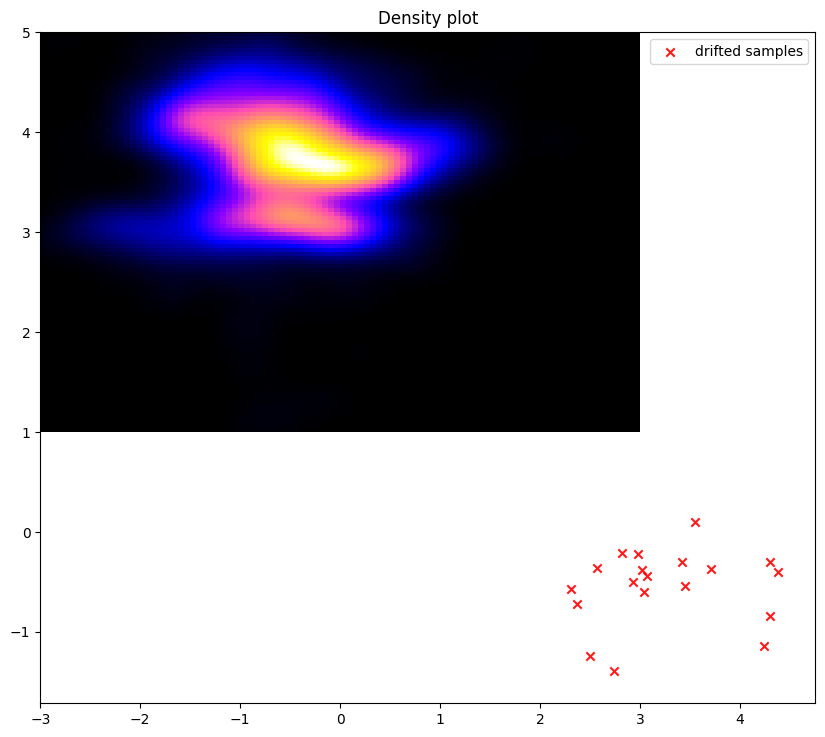

In [23]:
fig, ax = plt.subplots(figsize=(10,10))

# Plot density map
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(detector_wine.kde(positions).T, X.shape)
ax.imshow(np.rot90(Z), cmap=plt.cm.gnuplot2,
          extent=[-3, 3, 1, 5])

ax.scatter(embeddings_drift[is_anomaly,0], 
           embeddings_drift[is_anomaly,1], 
           marker='x', alpha=.9, color='r', label='drifted samples')

ax.set_title("Density plot");
plt.legend()

print(f"Using threshold {threshold_detection} -> Anomalies: {is_anomaly.sum()} | Percent anomalies {is_anomaly.sum()/len(is_anomaly)}")

Let us obtain explanations for each one of those mostt anomalous examples

In [24]:
explanations = detector_wine.explain(wine_drift[is_anomaly])
explanations.shape

(19, 11)

Now we can plot an "aggregate explanation" by calculating the average of all of them

Text(0.5, 1.0, 'Predicted $\\Delta$ for anomalies (in batch)')

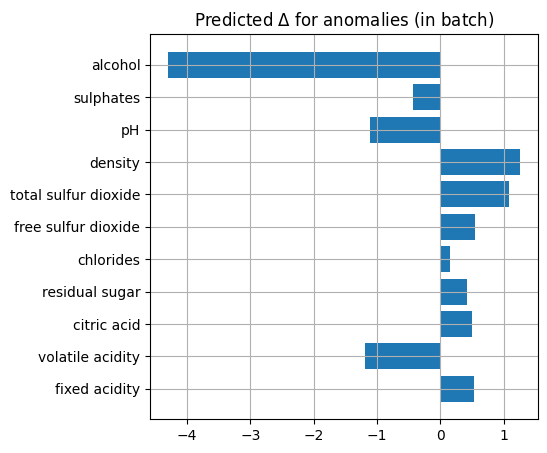

In [25]:
fig, ax = plt.subplots(figsize=(5,5))

ax.grid()

ax.barh(
    wine_drift.columns.tolist(), 
    explanations.mean(axis=0)  # Average explanation of all anomalous samples
)

ax.set_title("Predicted $\Delta$ for anomalies (in batch)")

As expected, because our "drifted" feature is `alcohol`, the explanations point that our drifted samples have high alcohol content (because the $\Delta$ of alcohol is the biggest one and negative)

# References

<a id="[1]">[1]</a> 
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis.
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.